In [321]:
!pip install numpy

In [322]:
import os
import joblib
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import pandas as pd

plt.rc('axes', facecolor='white')

In [323]:
DATA_DIR = '/kaggle/input/joblib-data'
if not os.path.exists(DATA_DIR):
    DATA_DIR = 'data'

In [324]:
! [ -e outputs ] || mkdir outputs
OUPTUT_DIR_PATH = 'outputs'
to_output = lambda file_path : os.path.join(OUPTUT_DIR_PATH,file_path)

# Ex1: Onehot coding DNA

Write a function called **onehot_dna(dna_str)** that allows to encode a DNA segment where each base is encoded as a vector of all zeros except one in a specific position. The result of this function is an array numpy.  DNA is a long chain of repeating bases strung together. There are 4 bases: A, C, G, T. For example, "AACCCAAATCGGGGG" is a DNA segment.



For example, **onehot_dna('AAT')** should return

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])






In [325]:
DNA_TABLE = "ACGT"
def onehot_dna(dna_str):
    one_hot = np.zeros((len(dna_str), 4),dtype=int)
    
    for i, base in enumerate(dna_str):
        if base in DNA_TABLE:
            one_hot[i, DNA_TABLE.index(base)] = 1
    
    return one_hot


In [326]:
onehot_dna('AAT')

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])

# Deep learning to classify Transcription Factor Biding


In the next exercises, we will learn how to use Deep learning to predict whether a segment of DNA does include or does not include a sit where JUND binds. (JUND is a particular transcription factor).

In this purpose, we will use data that is extracted from the chapter 6 of the book: 'Deep learning for the life science'. This book is written by B.Ramsundar, P.Eastman, P. Walters and V.Pande.


Data consist of DNA segments that have been split up from a full chromosome. Each segment is of 101 bases long and has been labeled to indicate whether it does or does not include a site where JUND binds to.


This is a binary classification problem.
The process of creating a PyTorch neural network binary classifier consists of several steps:

1. Prepare the training and test data

2. Implement a Dataset object to serve up the data

3. Design and implement a neural network

4. Write code to train the network

5. Write code to evaluate the model (the trained network)


# Ex 2:  Load Data

1. With the help of the joblib library, load the following files for training set:  **y_train.joblib**, **X_train.joblib**  and then store the results in variables **y_train, X_train** ,respectively.

In [327]:
## 1.
X_train = joblib.load(os.path.join(DATA_DIR,'X_train.joblib'))
y_train = joblib.load(os.path.join(DATA_DIR,'y_train.joblib'))

2. Do the same thing for the test set: load  **y_test.joblib**, **X_test.joblib**  and then store the results in variables **y_test, X_test**, respectively.

In [328]:
## 2.
X_test = joblib.load(os.path.join(DATA_DIR,'X_test.joblib'))
y_test = joblib.load(os.path.join(DATA_DIR,'y_test.joblib'))

3. What are the shape of **X_train** and **y_train** ? How many DNA segments are there in traning set ?

In [329]:
## 3.
print(f'{X_train.shape =}')
print(f'{y_train.shape =}')
print(f'There are {X_train.shape[0]} DNA segments int the training set.')

X_train.shape =(4672, 101, 4)
y_train.shape =(4672, 1)
There are 4672 DNA segments int the training set.


4. Display a DNA segment from **X_train** (using matplotlib.pyplot.imshow ).

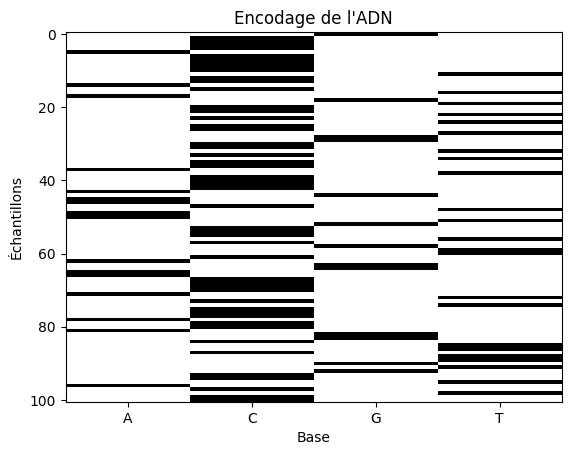

In [330]:
## 4.
dna_segment = random.choice(X_train)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(dna_segment, cmap='binary', aspect='auto')
ax.set_xticks(range(4),labels=list(DNA_TABLE))
ax.set_xlabel('Base')
ax.set_ylabel('Échantillons')
ax.set_title("Encodage de l'ADN")
fig.savefig(to_output('dna_encoded.png'))
plt.show()

5. Plot the histogram of **y_train** to see whether data is imbalanced or not.

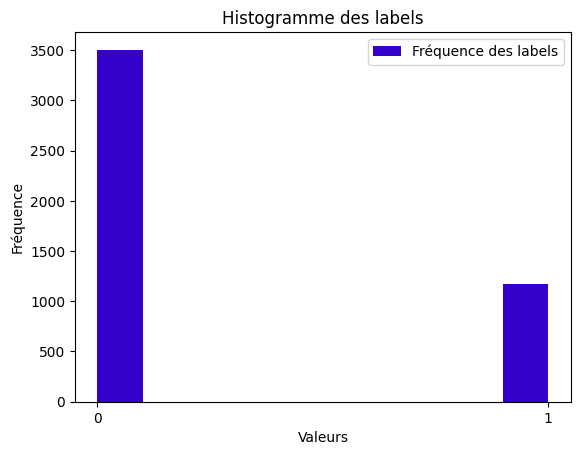

In [331]:
## 5.
fig = plt.figure()
ax = fig.add_subplot(111)
unique,counts = np.unique(y_train,return_counts=True)

ax.hist(unique.astype(int),weights=counts,label="Fréquence des labels",color=(0.2,0.0,0.8))  # Ajoute l'histogramme aux axes Matplotlib
ax.set_xticks(unique)
ax.set_xlabel("Valeurs")
ax.set_ylabel("Fréquence")
ax.set_title("Histogramme des labels")
ax.legend()
plt.show()
fig.savefig(to_output('label_frequency.png'))


# Ex 3: Convert numpy array to tensor pytorch

As you see in the previous exercise, **X_train** consists of 4672 segments. Each segment is encoded by 0 and 1 (one-hot encoding).


1. Convert numpy array **X_train**, **y_train** into pytorch tensor. Reshape **X_train** to (4672, 4, 101). Note that the type of **X_train** and **y_train** should be float.

2. Do the same thing for **X_test** and **y_test**


In [332]:
## 1.
import torch
X_train_ = X_train.astype(float)
X_train_ = X_train_.transpose(0,2,1)
assert X_train_.shape == (4672, 4, 101)
X_train_tensor = torch.from_numpy(X_train_)
X_train_tensor
y_train_tensor = torch.from_numpy(y_train.astype(float))
assert  X_train_tensor.size(0) == y_train_tensor.size(0)

In [333]:
## 2.
import torch
X_test_ = X_test.astype(float)
X_test_ = X_test_.transpose(0,2,1)

X_test_tensor = torch.from_numpy(X_test_)

y_test_tensor = torch.from_numpy(y_test.astype(float))
assert X_test_tensor.size(0) == y_test_tensor.size(0)
assert X_test_tensor.size()[1:] == X_train_tensor.size()[1:]


# Ex4: Create Dataset
In order to train a deep learning model with Pytorch, we need a pytorch dataset.
The DNADataset class below allows for creating a pytorch Dataset from DNA segments and their labels.

1. Using this class, create a dataset for training set. You should call it **train_dataset**

2. Create **Dataloader** from **train_dataset**. You should call it **train_loader**.

3. Do the same thing for the test set.

In [334]:
class DNADataset(torch.utils.data.Dataset):
    def __init__(self, dna, labels):
        self.labels = labels
        self.dna = dna


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        label = self.labels[idx]
        frag_dna = self.dna[idx]

        sample = {'DNA': frag_dna, 'Class': label}

        return sample

In [335]:
## 1.
train_dataset = DNADataset(X_train_tensor,y_train_tensor)

In [336]:
## 2.
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
next(iter(train_loader))['DNA'].size()

torch.Size([32, 4, 101])

In [337]:
## 3.
test_dataset = DNADataset(X_test_tensor,y_test_tensor)
test_loader = DataLoader(test_dataset)

# Design and implement a convolutional neural network

Now, it's time to build your model. This is a binary classification problem. We can use a convolution neural network, just like an image classification problem. However, since the size of a DNA segment is (4, 101), we will use 1D convolution instead of 2D convolution.



Firstly, we will test how does a 1D convolution work on our data.



# EX 5: 1D Convolution

1. With the help of the torch.nn.Conv1d class, create a 1D convolutional layer. You need to choose values for the following parameters: **in_channels**, **out_channels**, **kernel_size**.

In [338]:
## 1.
from torch  import nn

in_channels=4
out_channels=32
kernel_size=10
conv_layer = nn.Conv1d(in_channels=4,out_channels=32,kernel_size=10,dtype=float)

2. Apply this layer to **dna_seg** below. What is the size of the output ?

In [339]:
dna_seg = random.choice(train_dataset.dna)
dna_seg.size()

torch.Size([4, 101])

In [340]:
## 2.
conv_dna = conv_layer(dna_seg)
conv_dna.size()

torch.Size([32, 92])

3. [Optional] Display the output by using matplotlib.pyplot.imshow

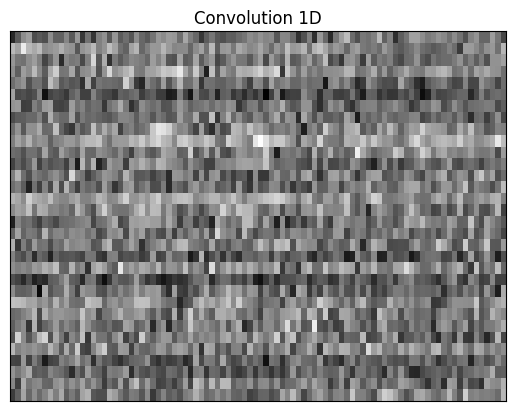

In [341]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(conv_dna.detach().numpy(), cmap='binary', aspect='auto')

ax.set_title("Convolution 1D")
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(to_output('conv_dna.png'))
plt.show()

# EX 6: Build a model

The following code is used to build a CNN model for a classification problem. This model consists of :

1. 3 layers of  1D-convolution. Each convolutional layer is followed by an activiation ReLu.

2. 2 Linear layers


Complete the lines # TODO below to finish the definition of this network.

In [342]:
import torch.nn as nn
import torch.nn.functional as F

class DeepDNA(nn.Module):
    def __init__(self, sequence_length=101):
        """
        Parameters
        -----------
        sequence_length: int
        num_class: int

        """
        super(DeepDNA,self).__init__()

        #### TO DO ####
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3, dtype=torch.double,padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, dtype=torch.double,padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, dtype=torch.double,padding=1)
        self.sequence_length = sequence_length
        self.lin1 = nn.Linear(64 * sequence_length, 32, dtype=torch.double)
        self.lin2 = nn.Linear(32, 1, dtype=torch.double)
        
    def forward(self, x):

        # 1/ pass the first convolutional layer
        #### TODO #####
        if(len(x.size())==2):
            x = x.unsqueeze(0)
        x = self.conv1(x)
        x = F.relu(x)
        # 2/ Pas the second convolutional layer
        #### TODO #####
        
        x = self.conv2(x)
        x = F.relu(x)
        # 3/ Pass the third convolution layer
        #### TODO #####
        
        x = self.conv3(x)
        x = F.relu(x)
        
        x = x.view(x.size(0),101*64)
        
        # TODO
        # Linear Classifier
        x =self.lin1(x)
        x =self.lin2(x)
        # Sigmoid
        x = nn.Sigmoid()(x)

        return x


# Ex 7 Test the model


1. Create an instance of the DeepDNA class named **net**.

In [343]:
## 1.
net = DeepDNA()

2. Print out the variable **net** to see detailed information about the model.

In [344]:
## 2.
net

DeepDNA(
  (conv1): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (lin1): Linear(in_features=6464, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=1, bias=True)
)

3. Pass **dna_seg** below to **net** in order to  test if your model **net** works well.

In [345]:
## 3.
out = net(dna_seg)
out 

tensor([[0.5277]], dtype=torch.float64, grad_fn=<SigmoidBackward0>)

4. What is the size of the output ?

In [346]:
## 4
out.size()

torch.Size([1, 1])

# Ex 8: Define loss function and optimizer


1. Define an SGD optimizer for the model. You need to choose the learning rate for your model.

2. Define a Binary Cross Entropy (BCE) Loss  function.


In [347]:
## 1.

learning_rate = 0.001  


optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
## 2.
loss_func = nn.BCELoss()

# Ex 9: Training your model

The following function allows to train the model for one epoch. This function returns total loss per epoch.
Implement the training pass for this function.



The general process with PyTorch for one learning step consits of several steps:

1. Make a forward pass through the network
2. Use the network output to calculate the loss
3. Perform a backward pass through the network with loss.backward() to calculate the gradients
4. Take a step with the optimizer to update the weights



In [348]:

def train_model(model,train_loader,optimizer,loss_func):
    model.train()
    
    for data in ((train_loader)):
        out = model(data['DNA'])
        loss = loss_func(out,data['Class'])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

# Ex 11: Accuracy Calculation

Write a function named **compute_num_correct_pred(y_prob, y_label)** that allows to compute the number of correct predictions. **y_prob** and **y_label** should be pytorch tensors.

For example,
y_prob = [[0.3],[0.4], [0.8], [0.7]].

y = [[0], [1], [1], [0]].

This function should return 2.

In [349]:
### TODO ####
def compute_num_correct_pred(y_prob:torch.tensor, y_label:torch.tensor):
    y_pred = (y_prob >= 0.5).float()
    correct_predictions = (y_pred == y_label).sum().item()
    
    return correct_predictions


The function below allows to calculate the accuracy of the model on dataset loader. Execute this function to see if you implemented the compute_num_correct_pred function correctly.

In [350]:
def test(loader,net):
    net.eval()
    correct = 0
    with torch.no_grad():
        for data in loader:
            dna = data['DNA']
            y = data['Class']
            out = net(dna)
            correct += compute_num_correct_pred(out, y)
    return correct / len(loader.dataset)



# Ex 12: Training the model

Write code to train your model on 10 epoches to see if everything is going well and then you can try to add more epoches.


In [351]:

def fit(net,train_loader,test_loader,optimizer,loss_func,epoches,file_name='history.csv'):
    train_accs = [test(train_loader,net)]
    test_accs = [test(test_loader,net)]

    for epoch in tqdm(range(epoches)):
        train_model(net,train_loader,optimizer,loss_func)
        train_acc = test(train_loader,net)
        test_acc =test(test_loader,net)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    history_df = pd.DataFrame({'train_accuracy':train_accs,'test_accuracy':test_accs})
    history_df.to_csv(to_output('history.csv'))
    return history_df

100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


<Axes: >

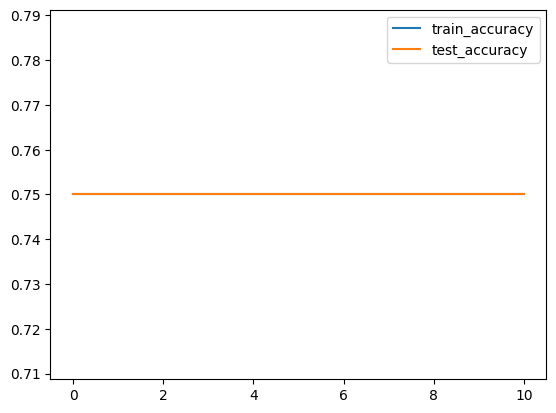

In [352]:
epoches = 10
net = DeepDNA()
learning_rate = 0.001  
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
loss_func = nn.BCELoss()
history_df = fit(net,train_loader,test_loader,optimizer,loss_func,epoches,file_name='BCE_history.csv')
history_df.plot()

# Ex13 (optional)

1. If we use torch.nn.BCEWithLogitsLoss(), what does we need to change to the definition of the model ?

100%|██████████| 10/10 [00:37<00:00,  3.76s/it]


<Axes: >

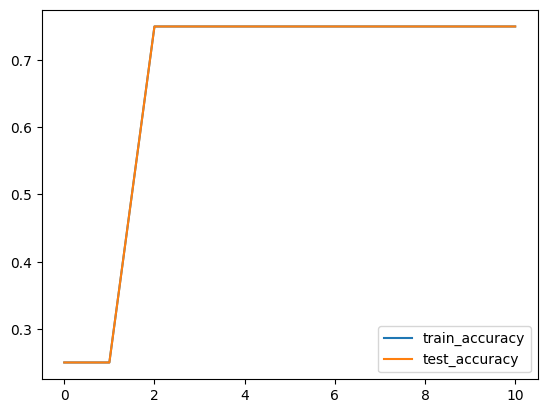

In [353]:
epoches = 10
net = DeepDNA()
learning_rate = 0.001  
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
loss_func = nn.BCEWithLogitsLoss()
history_df = fit(net,train_loader,test_loader,optimizer,loss_func,epoches,file_name='BCE_history.csv')
history_df.plot()

2. The same question for torch.nn.CrossEntropyLoss() loss.  

100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


<Axes: >

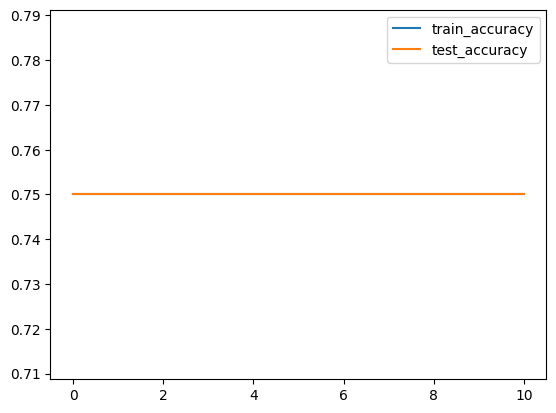

In [354]:
epoches = 10
net = DeepDNA()
learning_rate = 0.001  
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()
history_df = fit(net,train_loader,test_loader,optimizer,loss_func,epoches,file_name='CE_history.csv')
history_df.plot()

We see that for ` nn.CrossEntropyLoss` train_accuracy is slightly lower than the testing efficiency.